In [78]:
from utils import *
from environnement import Environnement
from policies import Policy,RandomPolicy,SmarterRandomPolicy
from tester import Tester
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings("ignore")

In [79]:
class EGreedyPolicy(Policy):
    """
    Example de policy qui fait un epsilon greedy (mais qui marche pas trop trop)
    
    """
    
    
    def __init__(self,params,seed):
        self.params = params
        self.seed = seed
        self.list_length = self.params["list_length"]
        self.n_bikes = self.params["n_bikes"]
        self.init()
        self.eps = self.params["eps"]
        self.__name__ = f"EGreedyPolicy_{params['price']}"
        

            
        
    def get_action(self,context):
        
        df = self.get_history() # La méthode pour récupérer l'historique
        
        df = df[df.user_id == context['user_id']]
        
        if self.rng.uniform() < self.eps or len(df) < 10:
        
            a = [len(d) for d in context["bikes_availability"]]

            chosen_index = self.rng.randint(0,len(a))  

            return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]
            return [context["bikes_available"][chosen_index]],[context['days_wanted']],[self.params["price"]]

        
        
        else:
            bikes_ids = pd.DataFrame({
                'bike_id':context["bikes_available"]
            })
            
            
            df = df.merge(bikes_ids,on='bike_id').groupby('bike_id').accepted.mean().reset_index().sort_values('accepted',ascending=True)
            
            chosen_index = context["bikes_available"].index(df.bike_id.values[0])
            
            return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]
            return [context["bikes_available"][chosen_index]],[context['days_wanted']],[self.params["price"]]

            
            else :
                
                #bikes_ids a une seule colonne 'bike_id' qui contient les id des bikes
                bikes_ids = pd.DataFrame({
                        'bike_id':context["bikes_available"]
                    })

                df = df.merge(bikes_ids,on='bike_id').groupby('bike_id').accepted.mean().reset_index().sort_values('accepted',ascending=True)

                #crée la colonne contenant le Nt(a) du dénominateur dans ucb
                df2 = self.get_history()[self.get_history().user_id == context['user_id']].groupby('bike_id').accepted.sum().reset_index()
                df2.columns=['bike_id','sum_accepted']

                df = df.merge(df2,on='bike_id')

                #on suppose c=1
                df['arg_ucb']=df.apply(lambda x : (x['accepted'] + np.sqrt(context['day']/x['sum_accepted'])),axis=1)

                df=df.reset_index().sort_values(by=['arg_ucb'],ascending=False)

                chosen_index = context["bikes_available"].index(df.bike_id.values[0])

                return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]

In [3]:
class UCBPolicy(Policy):
    """
    Exemple de UCB policy
    
    """
    
    
    def __init__(self,params,seed):
        self.params = params
        self.seed = seed
        self.list_length = self.params["list_length"]
        self.n_bikes = self.params["n_bikes"]
        self.init()
        self.__name__ = f"UCBPolicy_{params['price']}"
        
        
        
    def get_action(self,context):
        
        df = self.get_history() 
        u = df.copy()
        
        #on veut s'assurer que les Nt(a) ne valent pas 0 donc on doit attribuer chaque vélo au moins une fois
        if df.shape[0]<self.params["n_bikes"]:
            return [context["bikes_available"][df.shape[0]]],[context['bikes_availability'][df.shape[0]]],[self.params["price"]]
        
        else :

            df = df[df.user_id == context['user_id']]

            if len(df) < 10:
                a = [len(d) for d in context["bikes_availability"]]
                chosen_index = self.rng.randint(0,len(a))  
                return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]
                return [context["bikes_available"][chosen_index]],[context['days_wanted']],[self.params["price"]]

            
            else :
                
                #bikes_ids a une seule colonne 'bike_id' qui contient les id des bikes
                bikes_ids = pd.DataFrame({
                        'bike_id':context["bikes_available"]
                    })

                df = df.merge(bikes_ids,on='bike_id').groupby('bike_id').accepted.mean().reset_index().sort_values('accepted',ascending=True)

                #crée la colonne contenant le Nt(a) du dénominateur dans ucb
                
                
                df2 = u[u.user_id == context['user_id']].groupby('bike_id').accepted.sum().reset_index()
                df2.columns=['bike_id','sum_accepted']

                df = df.merge(df2,on='bike_id')

                #on suppose c=1
                df['arg_ucb']=df.apply(lambda x : (x['accepted'] + np.sqrt(context['day']/x['sum_accepted'])),axis=1)
                
                
                correction =    [    np.exp(-abs(len(days) - len(context['days_wanted']))) for days in context['bikes_availability']]
                correction = pd.DataFrame({"correction":correction,"bike_id":context["bikes_available"]})
                
                df = df.merge(correction,on="bike_id")
                
                df["arg_ucb"] = df["arg_ucb"]*df.correction

                df=df.reset_index().sort_values(by=['arg_ucb'],ascending=False)

                chosen_index = context["bikes_available"].index(df.bike_id.values[0])

                return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]
                return [context["bikes_available"][chosen_index]],[context['days_wanted']],[self.params["price"]]


In [4]:
from keras.layers import Embedding, Flatten, Dense, Dropout,Input
from keras.layers import Dot
from keras.models import Model


class DeepPolicy(Policy):
    """
    Example de policy qui fait un epsilon greedy (mais qui marche pas trop trop)
    
    """
    
    
    def __init__(self,params,seed):
        self.params = params
        self.seed = seed
        self.list_length = self.params["list_length"]
        self.n_bikes = self.params["n_bikes"]
        self.init()
        self.eps = self.params["eps"]
        self.__name__ = f"DeepPolicy_{params['price']}"
        
        
    def init(self):
        self.rng = np.random.RandomState(self.seed)
        self.history = []
        
        
        user_inputs = Input(shape=(1,))
        bike_inputs = Input(shape=(1,))
        
        user_embedding = Embedding(output_dim=self.params["embedding_size"],
                                        input_dim=self.params["n_users"],
                                        input_length=1,
                                        name='user_embedding')
        bike_embedding = Embedding(output_dim=self.params["embedding_size"],
                                        input_dim=self.params["n_bikes"],
                                        input_length=1,
                                        name='bike_embedding')
        
        user_vecs = Flatten()(user_embedding(user_inputs))
        bike_vecs = Flatten()(bike_embedding(bike_inputs))
        
        final_layer = Dot(axes=1)([user_vecs, bike_vecs])
        
        
        self.model = Model(inputs=[user_inputs,bike_inputs],outputs=[final_layer])
        
        
        self.model.compile(optimizer="adam", loss='mae') 
        

            
        
    def get_action(self,context):
        
        df = self.get_history() # La méthode pour récupérer l'historique
        
        df = df[df.user_id == context['user_id']]
        
        if len(df) < 100:
        
            a = [len(d) for d in context["bikes_availability"]]


            chosen_index = self.rng.randint(0,len(a))  

            return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]
            return [context["bikes_available"][chosen_index]],[context['days_wanted']],[self.params["price"]]
        
        
        else:
            
            X1,X2 =   df[["user_id","bike_id"]].values[:,0],df[["user_id","bike_id"]].values[:,1]
            y = df["accepted"].values
            
            
            
            
            self.model.fit([X1,X2],y,verbose=0)
            
            
            X1,X2 = [context["user_id"] for v in context["bikes_available"]], [v for v in context["bikes_available"]]
            
            
            ratings = self.model.predict([X1,X2])
            
            correction =    [    np.exp(-abs(len(days) - len(context['days_wanted']))) for days in context['bikes_availability']]
            
        
            ratings = [x*y for (x,y) in zip(ratings,correction)]
            
            chosen_index = np.argmax(ratings)
            
            return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]
            return [context["bikes_available"][chosen_index]],[context['days_wanted']],[self.params["price"]]
            
            
            
            
            
            
         

Using TensorFlow backend.


In [83]:
params = {
    'n_steps':1000,
    "n_rep":20
}
env_params = {
    'experiment_length':1000, # Beaucoup de jours
    "n_users":10, #peu d'utilisateur
    "n_clusters":5, # peu de vélos
    'dim':5,
    "n_bikes_per_user":1, # Un seul vélo proposé à chaque fois
    "users_per_day":1,
    'bike_overlapping':True
}
env = Environnement(env_params,5)

In [84]:
tester2 = Tester([
    UCBPolicy({"list_length":1,"price":10,"n_bikes":2,"eps":0.5},3),
],env,params)

In [85]:
tester2.run()







  0%|          | 0/5 [00:00<?, ?it/s]

Testing policy |UCBPolicy_10|








 20%|██        | 1/5 [00:18<01:15, 18.95s/it]





 40%|████      | 2/5 [00:37<00:56, 18.89s/it]/home/coralie/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in double_scalars






 60%|██████    | 3/5 [00:56<00:37, 18.77s/it]





 80%|████████  | 4/5 [01:14<00:18, 18.71s/it]





100%|██████████| 5/5 [01:32<00:00, 18.51s/it]







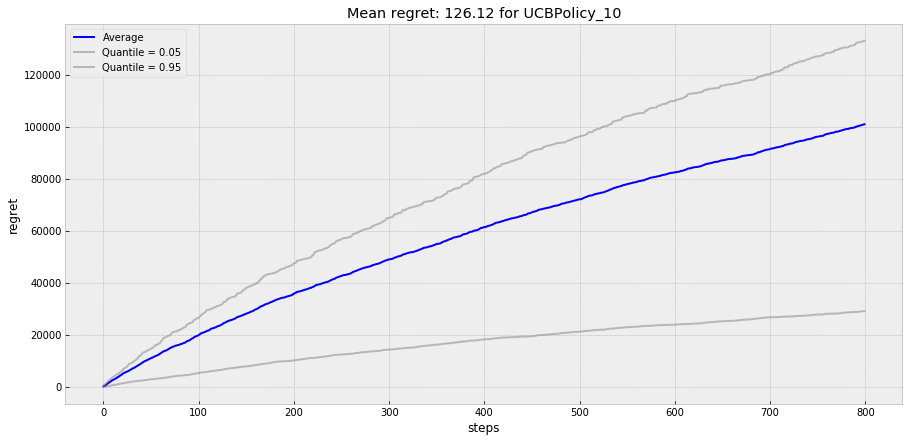

In [86]:
tester2.plotAllPoliciesQuantiles()

In [8]:
tester = Tester([
    UCBPolicy({"list_length":1,"price":500,"n_bikes":5,"eps":0.5},3),
    DeepPolicy({"list_length":1,"price":500,"n_bikes":5,"eps":0.5,"n_users":10,"embedding_size":5},3),
    EGreedyPolicy({"list_length":1,"price":500,"n_bikes":5,"eps":0.5},3),
    RandomPolicy({"list_length":1,"price":500},3),
    SmarterRandomPolicy({"list_length":1,"price":500},3),
    
    
],env,params)

In [ ]:
tester.run()

  0%|          | 0/20 [00:00<?, ?it/s]

Testing policy |UCBPolicy_500|


 20%|██        | 4/20 [01:30<06:02, 22.63s/it]

In [ ]:
tester.plotAllPoliciesQuantiles()

In [ ]:
tester.plotAllPoliciesCompared()